In [1]:
import numpy as np 
from scipy.integrate import solve_ivp
import jax
import jax.numpy as jnp
from jax import grad, random, vmap
import optax
from kernel_sca import *
from utils import *
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
import wandb

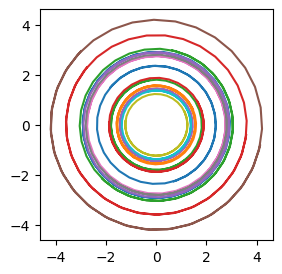

In [2]:
def rotation_system(t, y):
    x1, x2 = y
    dx1_dt = - x2 
    dx2_dt = x1 
    return [dx1_dt, dx2_dt]

def pendulum_system(t, y):
    x1, x2 = y
    dx1_dt = x2 
    dx2_dt = -np.sin(x1) 
    return [dx1_dt, dx2_dt]

def duffing_oscillator(t, y):
    x1, x2 = y
    dx1_dt = x2 
    dx2_dt = x1 - x1**3 
    return [dx1_dt, dx2_dt]

def van_der_pol(t, y):
    x1, x2 = y
    dx1_dt = x2 
    dx2_dt = (1 - x1**2) * x2 - x1 
    return [dx1_dt, dx2_dt]


t_span = (0, 10)                                    # simulate from t=0 to t=10 seconds
t_eval = np.linspace(t_span[0], t_span[1], 50)     # time points where the solution is computed


num_trajectories = 15

seed = 42
np.random.seed(seed) 
initial_conditions_list = np.random.uniform(low=-np.pi, high=np.pi, size=(num_trajectories, 2))

plt.figure(figsize=(3,3))
for initial_conditions in initial_conditions_list:
    solution = solve_ivp(rotation_system, t_span, initial_conditions, t_eval=t_eval)
    x1 = solution.y[0]
    x2 = solution.y[1]
    plt.plot(x1, x2, label=f'IC: {np.round(initial_conditions, 2)}')



In [4]:
def projected_X_linear(X, seed = 42, proj_dims = 10, plot=False):
    key = random.PRNGKey(seed)
    key, subkey = random.split(key)

    #Project X
    proj_matrix = random.normal(key, (proj_dims, X.shape[1]))
    proj_matrix , _ = jnp.linalg.qr(proj_matrix)                    #(N',N)
    X = jnp.einsum('lj,ijk->ilk', proj_matrix, X)                   #(K, N', T)
    
    #Observation noise 
    noise = random.normal(subkey, (X.shape)) 
    X += (noise)  /100
    X = jnp.array(X)

    if plot:
        plt.figure(figsize=(3,3))
        for i,initial_conditions in enumerate(initial_conditions_list):
            plt.plot(X[i,0,:],X[i,10,:] )
    return X
 

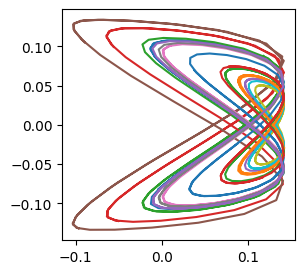

In [19]:
#Create X ( K = initial condition, N = (x1,x2), T = len(t_eval) )
X = np.zeros((num_trajectories, 2, len(t_eval)))
for i, initial_conditions in enumerate(initial_conditions_list):
    solution = solve_ivp(rotation_system, t_span, initial_conditions, t_eval=t_eval)
    x1 = solution.y[0]
    x2 = solution.y[1]

    X[i, 0, :] = x1
    X[i, 1, :] = x2
X = jnp.array(X)                                                                        #(K, N, T)

## 

D = 50
l = 2.5
mean = jnp.array([0.0, 0.0])  
covariance = jnp.array([[(1/l**2), 0.0], [0.0, (1/l**2)]])

key = random.PRNGKey(seed)
key, subkey = random.split(key)
num_samples = D
samples_omega = random.multivariate_normal(key, mean, covariance, shape=(num_samples,)) #(N',N)

dot_prod = jnp.einsum('lj,ijk->ilk', samples_omega, X)                                  #(K, N', T)
K, _, T = dot_prod.shape

cos_values = jnp.cos(dot_prod)
sin_values = jnp.sin(dot_prod)

phi = jnp.stack((cos_values, sin_values), axis=-2)
new_shape = (K, 2*D, T)
phi = phi.reshape(new_shape) * (1 / jnp.sqrt(D))                                        #(K, 2*N', T)

# noise = random.normal(subkey, (phi.shape)) 
# phi += (noise)  /100
# phi = jnp.array(phi)

plt.figure(figsize=(3,3))
for i,initial_conditions in enumerate(initial_conditions_list):
    plt.plot(phi[i,0,:],phi[i,-1,:] )

In [20]:
def K_X_Y_squared_exponential(X, Y, l=1.0, sigma_f=1.0):
    sq_dist = jnp.sum((X.T[:, jnp.newaxis, :] - Y.T[jnp.newaxis, :, :])**2, axis=2)
    return sigma_f**2 * jnp.exp(-0.5 / l**2 * sq_dist)

split = 5
X_train = phi[split:]
X_test = phi[:split]
K, N, T = X_train.shape

A = jnp.swapaxes(X_train, 0, 1)                  #(N, K, T)
A = A.reshape(N,-1)                              #(N, K*T)

# K_A_X = K_X_Y_identity(A, X_train)               #(K*T, K, T)
# K_A_A = K_X_Y_identity(A, A)

K_A_X = np.zeros((K*T, K, T))
for k in range(K):
    K_A_X[:,k,:] = K_X_Y_squared_exponential(A, X_train[k], l = l)
K_A_X = jnp.array(K_A_X)

K_A_A = jnp.array(K_X_Y_squared_exponential(A, A, l = l))

K_A_A_reshaped = K_A_A.reshape(K,T,K,T)                          #(K,T,K,T)
means = jnp.mean(K_A_A_reshaped, axis=(0, 2), keepdims=True)     #(1, T, 1, T)
K_A_A_tilde = (K_A_A_reshaped - means).reshape(K*T,K*T)          #(K*T,K*T)
P, S, Pt = jnp.linalg.svd(K_A_A_tilde, full_matrices=False)      #P is (K*T, K*T) and S is (K*T,)

In [21]:
d=2
wandb.init(project="SCA-project-toydata-kernel", name="run_1", mode="disabled")
alpha_tilde, ls_loss, ls_S_ratio = optimize(P, S, K_A_X, X_train, d=d, learning_rate=0.01, iterations=1000) 
wandb.finish

Iteration 0, S: 4.376932338345796e-06, S_ratio: 0.1343591809272766
Iteration 10, S: 1.085031090042321e-05, S_ratio: 0.18681344389915466
Iteration 20, S: 2.4180555556085892e-05, S_ratio: 0.20982973277568817
Iteration 30, S: 6.150230910861865e-05, S_ratio: 0.2356269806623459
Iteration 40, S: 0.00016494169540237635, S_ratio: 0.25452980399131775
Iteration 50, S: 0.0004395224095787853, S_ratio: 0.26169613003730774
Iteration 60, S: 0.0011530823539942503, S_ratio: 0.27436742186546326
Iteration 70, S: 0.0030858961399644613, S_ratio: 0.2675519585609436
Iteration 80, S: 0.007463888265192509, S_ratio: 0.25275442004203796
Iteration 90, S: 0.0160893015563488, S_ratio: 0.2421806901693344
Iteration 100, S: 0.02999293804168701, S_ratio: 0.23495431244373322
Iteration 110, S: 0.0524170808494091, S_ratio: 0.24110357463359833
Iteration 120, S: 0.07985620200634003, S_ratio: 0.24865858256816864
Iteration 130, S: 0.1001969650387764, S_ratio: 0.2628667950630188
Iteration 140, S: 0.12871786952018738, S_ratio: 

<function wandb.sdk.wandb_run.finish(exit_code: Optional[int] = None, quiet: Optional[bool] = None) -> None>

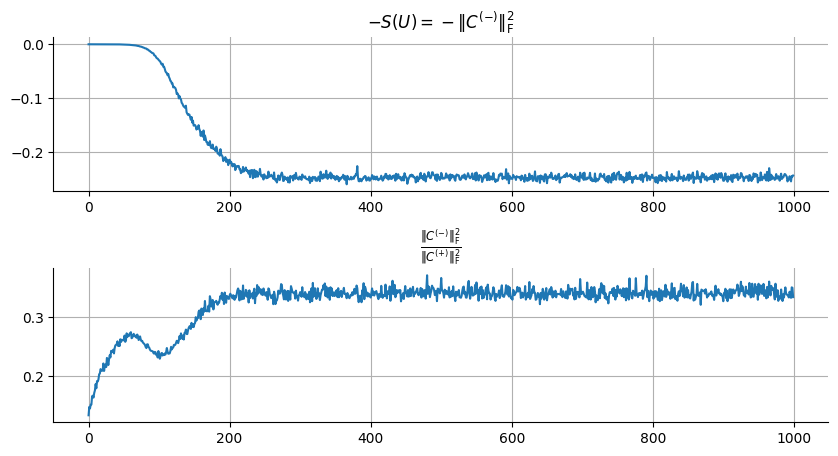

In [22]:
plt.figure(figsize=(10,5))
plt.subplot(211)
plt.plot(ls_loss)
plt.grid()
plt.title(r"$-S(U) = -\|C^{(-)}\|_\mathrm{F}^2$")
plt.gca().spines[['top','right']].set_visible(False)
plt.subplot(212)
plt.plot(ls_S_ratio)
plt.title(r"$\frac{\|C^{(-)}\|_\mathrm{F}^2}{\|C^{(+)}\|_\mathrm{F}^2}$")
plt.gca().spines[['top','right']].set_visible(False)
plt.grid()
plt.subplots_adjust(hspace=0.5)

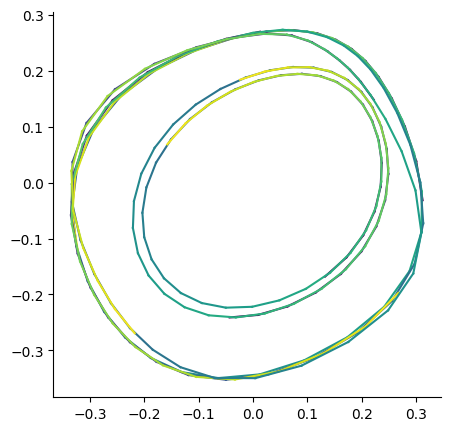

In [23]:
alpha_tilde_QR, _ = jnp.linalg.qr(alpha_tilde) 
alpha = (P / jnp.sqrt(S)) @ alpha_tilde_QR

alpha_reshaped = alpha.reshape(K,T,d)                                           #(K, T, d)
mean = jnp.mean(alpha_reshaped, axis=(0), keepdims=True)                        #(1, T, d)
alpha_H = (alpha_reshaped - mean).reshape(K*T,d)                      #(K*T,d)

K_test, _, _ = X_test.shape
K_A_X_test = np.zeros((K*T, K_test, T))
for k in range(K_test):
    K_A_X_test[:,k,:] = K_X_Y_squared_exponential(A, X_test[k], l = l)
K_A_X_test = jnp.array(K_A_X_test)

#K_A_X_test = K_X_Y_identity(A, X_test)                                     #(K*T, K, T)

projection = jnp.einsum('ij,imk->mjk', alpha_H, K_A_X_test)                #(K*T,d) @ (K*T, K, T) --> (K, d, T)


plot_2D(projection)
#plt.title(f"sca {var_explained(K_A_X, optimized_alpha_H):.2f}")

Text(0.5, 1.0, 'pca 0.65')

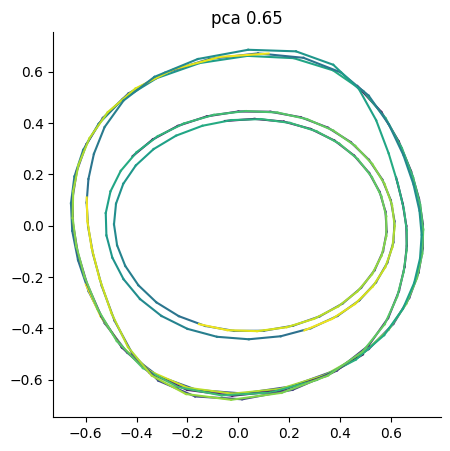

In [24]:
""" PCA """
X_train_pca = np.concatenate(X_train.swapaxes(1,2))
X_test_pca = np.concatenate(X_test.swapaxes(1,2))
full_data_var = np.sum(np.var(X_test, axis=0))

num_pcs = 2
pca = PCA(num_pcs)
Y_pca = pca.fit(X_train_pca).transform(X_test_pca)
PCs = pca.components_
Y_pca = Y_pca.reshape(-1, len(t_eval), num_pcs).swapaxes(1,2)
pca_variance_captured = pca.explained_variance_ratio_

plot_2D(Y_pca)
plt.title(f"pca {var_explained(X_test, PCs[:2].T):.2f}")


